In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [ ]:
# Load the CSV file with player names and genders
csv_file_path = r"D:\Big Data Project\Tryyyy.csv"  # Update this with the actual path
df_players = pd.read_csv(csv_file_path)

In [ ]:
# Create a DataFrame with image paths and file names
def list_directory_contents(directory):
    contents = []
    for root, dirs, files in os.walk(directory):
        for name in files:
            contents.append(os.path.join(root, name))
    return contents

images_directory = "D:\Big Data Project\Extraction"  # Update with the path to your images
extracted_files = list_directory_contents(images_directory)

image_data = {'ImageName': [], 'ImagePath': []}
for file_path in extracted_files:
    base_name = os.path.basename(file_path)
    player_name = os.path.splitext(base_name)[0]
    image_data['ImageName'].append(player_name)
    image_data['ImagePath'].append(file_path)

df_images = pd.DataFrame(image_data)

In [ ]:
# Extract player names from image file names for merging
def extract_player_name(image_name):
    parts = image_name.split('_')
    player_name = ' '.join(parts[:2])
    return player_name

df_images['PlayerName'] = df_images['ImageName'].apply(extract_player_name)

In [ ]:
# Merge the DataFrames
df_merged = pd.merge(df_players, df_images, left_on='Name', right_on='PlayerName', how='left')
df_merged.dropna(subset=['ImagePath'], inplace=True)

In [ ]:
# Preprocess the images
def preprocess_image(img_path):
    try:
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array / 255.0
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

In [ ]:
# Apply preprocessing and filter out None values
preprocessed_images = [preprocess_image(path) for path in df_merged['ImagePath']]
image_data = np.vstack([img for img in preprocessed_images if img is not None])

Error processing image D:\Big Data Project\Extraction\Images\Ibrahim_Cissoko_UEL_Road_to_the_Knockouts_88_OVR.jpg: cannot identify image file <_io.BytesIO object at 0x0000022F2CACEE30>


In [ ]:
# Update labels to match the filtered images
valid_indices = [i for i, img in enumerate(preprocessed_images) if img is not None]
df_merged_valid = df_merged.iloc[valid_indices]

In [ ]:
# Convert gender to numerical labels
gender_to_label = {'Male': 0, 'Female': 1}
df_merged_valid['GenderLabel'] = df_merged_valid['gender'].map(gender_to_label)
labels = to_categorical(df_merged_valid['GenderLabel'], num_classes=2)

C:\Users\dell\AppData\Local\Temp\ipykernel_1924\3204863600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_valid['GenderLabel'] = df_merged_valid['gender'].map(gender_to_label)


In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_data, labels, test_size=0.2, random_state=42)

In [ ]:
# Define and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
11/11 [==============================] - 10s 752ms/step - loss: 0.7549 - accuracy: 0.6972 - val_loss: 0.5386 - val_accuracy: 0.7317
Epoch 2/10
11/11 [==============================] - 8s 731ms/step - loss: 0.4989 - accuracy: 0.7859 - val_loss: 0.5192 - val_accuracy: 0.7317
Epoch 3/10
11/11 [==============================] - 8s 774ms/step - loss: 0.4960 - accuracy: 0.7859 - val_loss: 0.5960 - val_accuracy: 0.7317
Epoch 4/10
11/11 [==============================] - 10s 866ms/step - loss: 0.4610 - accuracy: 0.7859 - val_loss: 0.5059 - val_accuracy: 0.7317
Epoch 5/10
11/11 [==============================] - 10s 895ms/step - loss: 0.4296 - accuracy: 0.7859 - val_loss: 0.6831 - val_accuracy: 0.7317
Epoch 6/10
11/11 [==============================] - 10s 946ms/step - loss: 0.4322 - accuracy: 0.7920 - val_loss: 0.4669 - val_accuracy: 0.7317
Epoch 7/10
11/11 [==============================] - 10s 902ms/step - loss: 0.4103 - accuracy: 0.7951 - val_loss: 0.4722 - val_accuracy: 0.7683
E

In [ ]:
# Save the model
model.save('gender_classification_model.h5')

D:\jupyter\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

3/3 [==============================] - 0s 162ms/step - loss: 0.4910 - accuracy: 0.8171
Validation accuracy: 81.71%


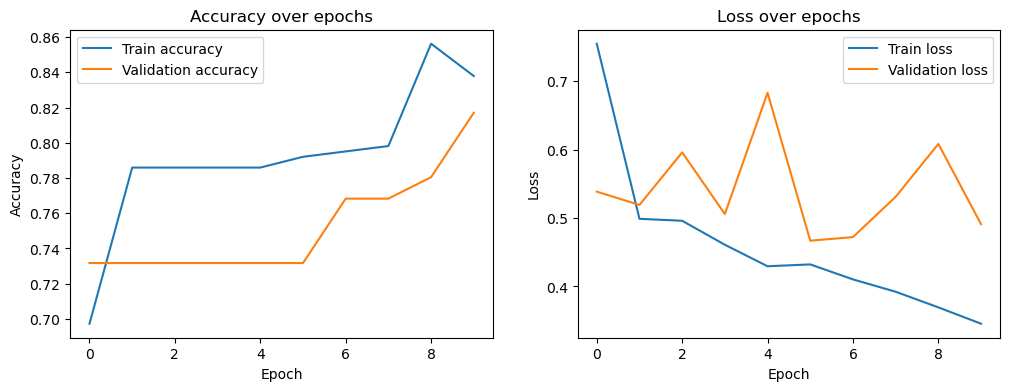

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Function to preprocess and predict new image
def classify_new_image(image_path, model_path):
    try:
        # Load the trained model
        model = load_model(model_path)

        # Preprocess the image
        new_image = preprocess_image(image_path)

        # Predict gender
        prediction = model.predict(new_image)
        predicted_gender = 'Male' if prediction[0][0] > prediction[0][1] else 'Female'

        return predicted_gender
    except Exception as e:
        print(f"Error in classifying image {image_path}: {e}")
        return None

In [ ]:
# Example usage
new_image_path = "D:\Big Data Project\Extraction\Images\Alexia_Putellas_Rare_91_OVR.jpg"  # Replace with the path to a new image
model_path = 'gender_classification_model.h5'
predicted_gender = classify_new_image(new_image_path, model_path)
print(f"The predicted gender for the image is: {predicted_gender}")

1/1 [==============================] - 0s 233ms/step
The predicted gender for the image is: Female
